In [1]:
import pandas as pd
import numpy as np
import nltk
import string
#import fasttext
#import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [2]:
from snownlp import SnowNLP

In [3]:
text = SnowNLP(u'口感很好，喝起来味道不错，包装也很精美，送人也很大气。')
sent = text.sentences
for sen in sent:
    s = SnowNLP(sen)
    print(s.sentiments)

0.9052074671668017
0.7045793841375075
0.8142993898625756
0.7122102717678036


In [4]:
print(s.words)

['送', '人', '也', '很', '大', '气']


In [5]:
list(s.tags)

[('送', 'v'), ('人', 'n'), ('也', 'd'), ('很', 'd'), ('大', 'a'), ('气', 'n')]

In [6]:
#plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

In [7]:
train = pd.read_csv("teapro.csv", encoding="GBK")

In [8]:
print(train)

        no                  rateContent  package  quality  price  service  \
0        1  口感很好，喝起来味道不错，包装也很精美，送人也很大气。        1        1      0        0   
1        2  送朋友的，如果里盒不破就更好了，细节也很重要哦，谢谢！        1        0      0        0   
2        3            茶的味道很纯正，使用方便，包装很好        1        1      0        0   
3        4              茶叶不错，味道挺好的，5分好评        0        1      0        0   
4        5                     口感特别好~~！        0        1      0        0   
...    ...                          ...      ...      ...    ...      ...   
3842  3843                很好，很新鲜，不错，好评！        0        0      0        0   
3843  3844               不错，是正品，下次还会再来。        0        1      0        0   
3844  3845      老板态度好，发货及时，茶叶很好，口感很好，甘甜        0        1      0        1   
3845  3846                     哎，，，，，，，        0        0      0        0   
3846  3847                       味道真的不错        0        1      0        0   

      logistics  other  sentiment  
0             0      0          0  
1  

In [9]:
#pip install transformers

In [10]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [11]:
len(tokenizer.vocab)

21128

In [12]:
print(train.loc[:,"rateContent"])

0       口感很好，喝起来味道不错，包装也很精美，送人也很大气。
1       送朋友的，如果里盒不破就更好了，细节也很重要哦，谢谢！
2                 茶的味道很纯正，使用方便，包装很好
3                   茶叶不错，味道挺好的，5分好评
4                          口感特别好~~！
                   ...             
3842                  很好，很新鲜，不错，好评！
3843                 不错，是正品，下次还会再来。
3844        老板态度好，发货及时，茶叶很好，口感很好，甘甜
3845                       哎，，，，，，，
3846                         味道真的不错
Name: rateContent, Length: 3847, dtype: object


In [13]:
training_data_list = []
print(train.loc[:,"rateContent"][0])

口感很好，喝起来味道不错，包装也很精美，送人也很大气。


In [14]:
print(len(train.loc[:,"rateContent"]))

3847


In [15]:
for i in range(len(train.loc[:,"rateContent"])-100):
    training_data_list.append(train.loc[:,"rateContent"][i])

In [16]:
vali_data_list = []
for j in range(len(train.loc[:,"rateContent"])-100,len(train.loc[:,"rateContent"])):
    vali_data_list.append(train.loc[:,"rateContent"][j])

In [17]:
label_list = []
for i in range(len(train.loc[:,"rateContent"])-100):
    label_list.append(train.loc[:,"package"][i])

In [18]:
vali_label_list = []
for j in range(len(train.loc[:,"rateContent"])-100,len(train.loc[:,"rateContent"])):
    vali_label_list.append(train.loc[:,"package"][j])

In [19]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            sent, # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=64,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [20]:
train_inputs, train_masks = preprocessing_for_bert(training_data_list)
val_inputs, val_masks = preprocessing_for_bert(vali_data_list)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/shijunliang/Desktop/enter/envs/transform/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(label_list)
val_labels = torch.tensor(vali_label_list)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [22]:
class Config(object):
    embed_size = 300
    hidden_size = 10
    output_size = 4
    max_epochs = 30
    lr = 0.5
    batch_size = 128

In [23]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from transformers import BertModel

In [24]:
class fastText(nn.Module):
    def __init__(self, config, vocab_size, word_embeddings):
        super(fastText, self).__init__()
        self.config = config
        
        # Embedding Layer
        #self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
        #self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Hidden Layer
        self.fc1 = nn.Linear(self.config.embed_size, self.config.hidden_size)
        
        # Output Layer
        self.fc2 = nn.Linear(self.config.hidden_size, self.config.output_size)
        
        # Softmax non-linearity
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        #embedded_sent = self.embeddings(x).permute(1,0,2)
        texts = self.bert(x)[0].detach_()

        texts = texts.permute(0, 2, 1)
        #if bool(self.dropout[0]):
        #    texts = self.drp1(texts) 
        h = self.fc1(texts.mean(1))
        z = self.fc2(h)
        return self.softmax(z)

In [25]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    fastText = fastText(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    fastText.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [26]:
  for step, batch in enumerate(train_dataloader):
            #batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)
            print(b_input_ids.shape)
            print(b_labels.shape)

torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([32, 64])
torch.Size([32])
torch.Size([

In [27]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        #model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            #print(b_labels.dtype)
            #print(b_labels)
            #print(b_labels.shape)
            #b_labels = b_labels.float32
            #b_labels = torch.tensor(b_labels,dtype=torch.float32)
            
            # Zero out any previously calculated gradients
            optimizer.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)
            #logits = torch.tensor(logits,dtype=torch.float32)
            #print(logits.shape)
            #print(logits.dtype)
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        #b_label = torch.float(b)
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [28]:
     
device = torch.device("cuda:0")


In [29]:
class Config(object):
    embed_size = 64
    hidden_size = 368
    output_size = 4
    max_epochs = 30
    lr = 0.5
    batch_size = 128

In [30]:
set_seed(42)    # Set seed for reproducibility
#bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
#params.update(learning_params)
#params.update(cnn_params)
#net = FastText(params)
config = Config()
net = fastText(config, 3500, 768)
net = net.to(device)
optimizer = AdamW(net.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )
total_steps = len(train_dataloader) *4
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
train(net, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/shijunliang/Desktop/enter/envs/transform/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/tmp/ipykernel_67987/2328506674.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(z)


   1    |   20    |   1.394686   |     -      |     -     |   1.01   
   1    |   40    |   1.384746   |     -      |     -     |   0.55   
   1    |   60    |   1.375274   |     -      |     -     |   0.55   
   1    |   80    |   1.365365   |     -      |     -     |   0.55   
   1    |   100   |   1.355856   |     -      |     -     |   0.55   
   1    |   117   |   1.348251   |     -      |     -     |   0.46   
----------------------------------------------------------------------
   1    |    -    |   1.371470   |  1.339903  |   92.97   |   3.74   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   1.339395   |     -      |     -     |   0.59   
   2    |   40    |   1.330119   |     -      |     -     |   0.58   
   2    |   60    |   1.319632   |     -      |     -     |   0.56   
   2    |   80 

In [31]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
             logits = model(b_input_ids)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [32]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [33]:
import matplotlib.pyplot as plt

AUC: 0.6545
Accuracy: 91.00%


/tmp/ipykernel_67987/2328506674.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(z)


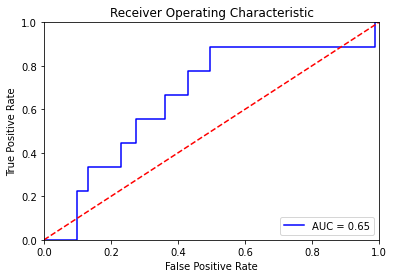

In [34]:
# Compute predicted probabilities on the test set
probs = bert_predict(net, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, val_labels)